# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
pd.set_option('max_colwidth', None)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('AZDIAS.csv')

C:\Users\mrnpe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
customers = pd.read_csv('CUSTOMERS.csv')

In [5]:
mailout_train = pd.read_csv('MAILOUT_TRAIN.csv')

In [6]:
mailout_test = pd.read_csv('MAILOUT_test.csv')

In [7]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 367 entries, Unnamed: 0 to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 2.4+ GB


In [8]:
azdias.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [9]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 370 entries, Unnamed: 0 to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(95), object(8)
memory usage: 541.0+ MB


In [10]:
customers.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [11]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 368 entries, Unnamed: 0 to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(95), object(6)
memory usage: 120.6+ MB


In [12]:
mailout_train.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [13]:
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 367 entries, Unnamed: 0 to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 119.9+ MB


In [14]:
mailout_test.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [15]:
# Let's drop unnamed: 0
azdias.drop('Unnamed: 0', axis=1, inplace=True)
customers.drop('Unnamed: 0', axis=1, inplace=True)
mailout_train.drop('Unnamed: 0', axis=1, inplace=True)
mailout_test.drop('Unnamed: 0', axis=1, inplace=True)

## Part 1: Customer Segmentation Report

### A. Data Cleaning

#### a. Load data range values

In [16]:
# We will read the dictionnary of values wich is in an xls file and check that our dataframe has an expected range
# of values for each features

attributes = pd.read_excel(
    'DIAS Attributes - Values 2017.xlsx', skiprows=[0], usecols='B:E')
attributes.fillna(method='ffill', inplace=True)

In [17]:
# Some values are string with 2 values separated by ','. Let's reformat.

to_append = {'Attribute': [], 'Description': [], 'Value': [], 'Meaning': []}
attributes['Value split'] = attributes['Value'].apply(
    lambda x: x.split(',') if type(x) == str else x)

for i in range(attributes.shape[0]):
    if (type(attributes.iloc[i, 4]) == list) and len(attributes.iloc[i, 4]) > 1:
        attributes.iloc[i, 2] = int(attributes.iloc[i, 4][0].strip())
        to_append['Attribute'].append(attributes.iloc[i, 0])
        to_append['Description'].append(attributes.iloc[i, 1])
        to_append['Value'].append(int(attributes.iloc[i, 4][1].strip()))
        to_append['Meaning'].append(attributes.iloc[i, 3])
        attributes.iloc[i, 4] = attributes.iloc[i, 2]

attributes.drop('Value split', axis=1, inplace=True)
attributes = pd.concat([attributes, pd.DataFrame(to_append)])

In [18]:
# lets create a dictionnary with range of values for each feature
dic_value = {}
for attribute in attributes['Attribute'].unique():
    dic_value[attribute] = attributes[attributes['Attribute']
                                      == attribute]['Value'].to_list()

#### b. Mixed Dtypes

In [19]:
# let's check the columns with mixed dtypes in azdias
print('Azdias')
print(azdias.iloc[:, 18:20].columns)

Azdias
Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


In [20]:
# Looking at the documentation these are the "CAMEO classification 2015 - Uppergroup" -values from -1 to 9 integers-
# and I guess as i can't find the exact field "CAMEO classification 2015 - international typology" -values are integers.

print('CAMEO_DEUG_2015')
print(azdias.iloc[:, 18].unique())
print('')
print('CAMEO_INTL_2015')
print(azdias.iloc[:, 19].unique())

CAMEO_DEUG_2015
[nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']

CAMEO_INTL_2015
[nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44'
 '35' '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45'
 'XX']


In [21]:
# So the issue is because of 'X' and 'XX'. Let's check in the dictionnary if we can have 'X' or 'XX' values

In [22]:
for key in dic_value.keys():
    if ('X' in dic_value[key]) or ('XX' in dic_value[key]):
        print(f'There can be X or XX values for {key}')

In [23]:
# There can not be X or XX values. We replace all X or XX by np.nan

azdias.replace(to_replace='X', value=np.nan, inplace=True)
azdias.replace(to_replace='XX', value=np.nan, inplace=True)
customers.replace(to_replace='X', value=np.nan, inplace=True)
customers.replace(to_replace='XX', value=np.nan, inplace=True)
mailout_train.replace(to_replace='X', value=np.nan, inplace=True)
mailout_train.replace(to_replace='XX', value=np.nan, inplace=True)
mailout_test.replace(to_replace='X', value=np.nan, inplace=True)
mailout_test.replace(to_replace='XX', value=np.nan, inplace=True)

In [24]:
# We are also specify the type of azdias for these 2 columns as floats so there is '1' is the same as 1.0 for example

azdias[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']] = azdias[[
    'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].astype(float)

#### c. Values check

In [25]:
# Lets create a function to check what if the columns in the df are in the dictionnary or not.
# If they are lets check that the range of values is acceptable

def value_range_check(df, dic=dic_value):

    # First check columns
    not_found = []
    for col in df.columns:
        if col not in dic.keys():
            not_found.append(col)

    # For columns found, check the range of values for the non numericals one
    range_issue = {}
    numeric_range = {}
    for col in np.setdiff1d(df.columns, not_found):
        for val in df[col].unique():

            # We specify the first condition to not take into account nan values and the second to exclude numerical ones
            if (val == val) and (val not in dic_value[col]) and (dic_value[col][0] != '…'):
                if col not in range_issue.keys():
                    range_issue[col] = [val]
                else:
                    range_issue[col].append(val)

    # For numericals one, retrieve the min-max
            elif (val == val) and (dic_value[col][0] == '…'):
                numeric_range[col] = (df[col].min(), df[col].max())
                break  # we get out of the value check for this column

    return not_found, range_issue, numeric_range

In [26]:
# first let's check that the columns not found are all the same accross the dataframes
not_found_azdias, range_issue_azdias, numeric_range_azdias = value_range_check(
    azdias)
not_found_customers, range_issue_customers, numeric_range_customers = value_range_check(
    customers)
not_found_mailout_train, range_issue_mailout_train, numeric_range_mailout_train = value_range_check(
    mailout_train)
not_found_mailout_test, range_issue_mailout_test, numeric_range_mailout_test = value_range_check(
    mailout_test)

In [27]:
np.setdiff1d(not_found_customers, not_found_azdias)

array(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype='<U26')

In [28]:
# This is expected as explained in the introduction. Besides these 3 columns, all the columns not found between
# azdias and customers are the smame

In [29]:
np.setdiff1d(not_found_customers, not_found_mailout_train)

array(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype='<U26')

In [30]:
np.setdiff1d(not_found_mailout_train, not_found_mailout_test)

array(['RESPONSE'], dtype='<U26')

In [31]:
# The above is expected. the test set does not have the filed response. It is scored on Kaggle platform.

In [32]:
# ok same here. Let's just check that mailout_train should have one more which is the RESPONSE
np.setdiff1d(not_found_mailout_train, not_found_azdias)

array(['RESPONSE'], dtype='<U26')

In [33]:
# what are the not found features ?
len(not_found_azdias)

94

In [34]:
not_found_azdias

['LNR',
 'AKT_DAT_KL',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP_MAX',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_SOZIALES',
 'D19_TECHNIK',
 'D19_TELKO_MOBILE',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'D19_VERSAND_REST',
 'D19_VERSI_DATUM

In [35]:
# 93 features are not present in attributes file -we know LNR is an id-. Looking at the names these are likely categorical features

In [36]:
# Ok that was expected. Let's check the range of issues

In [37]:
range_issue_azdias

{'KBA05_MODTEMP': [6.0],
 'LP_FAMILIE_FEIN': [0.0],
 'LP_FAMILIE_GROB': [0.0],
 'LP_LEBENSPHASE_FEIN': [0.0],
 'LP_LEBENSPHASE_GROB': [0.0],
 'ORTSGR_KLS9': [0.0]}

In [38]:
range_issue_customers

{'CAMEO_DEUG_2015': ['6', '3', '8', '9', '2', '4', '1', '7', '5'],
 'KBA05_MODTEMP': [6.0],
 'LP_FAMILIE_FEIN': [0.0],
 'LP_FAMILIE_GROB': [0.0],
 'LP_LEBENSPHASE_FEIN': [0.0],
 'LP_LEBENSPHASE_GROB': [0.0]}

In [39]:
range_issue_mailout_train

{'CAMEO_DEUG_2015': ['4', '6', '2', '9', '8', '7', '3', '1', '5'],
 'KBA05_MODTEMP': [6.0],
 'LP_FAMILIE_FEIN': [0.0],
 'LP_FAMILIE_GROB': [0.0],
 'LP_LEBENSPHASE_FEIN': [0.0],
 'LP_LEBENSPHASE_GROB': [0.0],
 'ORTSGR_KLS9': [0.0]}

In [40]:
range_issue_mailout_test

{'CAMEO_DEUG_2015': ['2', '5', '7', '9', '4', '6', '1', '3', '8'],
 'KBA05_MODTEMP': [6.0],
 'LP_FAMILIE_FEIN': [0.0],
 'LP_FAMILIE_GROB': [0.0],
 'LP_LEBENSPHASE_FEIN': [0.0],
 'LP_LEBENSPHASE_GROB': [0.0],
 'ORTSGR_KLS9': [0.0]}

In [41]:
# These are all the same except CAMEO_DEUG_2015 because of some values seen as string for customers mailout_train and mailout_test.
# let's fix this

customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].astype(float)
mailout_train['CAMEO_DEUG_2015'] = mailout_train['CAMEO_DEUG_2015'].astype(
    float)
mailout_test['CAMEO_DEUG_2015'] = mailout_test['CAMEO_DEUG_2015'].astype(
    float)

In [42]:
range_issue_customers = value_range_check(customers)[1]
range_issue_customers

{'KBA05_MODTEMP': [6.0],
 'LP_FAMILIE_FEIN': [0.0],
 'LP_FAMILIE_GROB': [0.0],
 'LP_LEBENSPHASE_FEIN': [0.0],
 'LP_LEBENSPHASE_GROB': [0.0]}

In [43]:
range_issue_mailout_train = value_range_check(mailout_train)[1]
range_issue_mailout_train

{'KBA05_MODTEMP': [6.0],
 'LP_FAMILIE_FEIN': [0.0],
 'LP_FAMILIE_GROB': [0.0],
 'LP_LEBENSPHASE_FEIN': [0.0],
 'LP_LEBENSPHASE_GROB': [0.0],
 'ORTSGR_KLS9': [0.0]}

In [44]:
range_issue_mailout_test = value_range_check(mailout_test)[1]
range_issue_mailout_test

{'KBA05_MODTEMP': [6.0],
 'LP_FAMILIE_FEIN': [0.0],
 'LP_FAMILIE_GROB': [0.0],
 'LP_LEBENSPHASE_FEIN': [0.0],
 'LP_LEBENSPHASE_GROB': [0.0],
 'ORTSGR_KLS9': [0.0]}

In [45]:
# Ok. Now we have the same exact range issues

# 'KBA05_MODTEMP': supposed to be up to 5 or 9
# 'LP_FAMILIE_FEIN':  supposed to be between 1 and 11
# 'LP_FAMILIE_GROB': supposed to be between 1 and 11
# 'LP_LEBENSPHASE_FEIN': supposed to be between 1 and 40
# 'LP_LEBENSPHASE_GROB': supposed to be between 1 and 12
# 'ORTSGR_KLS9': supposed to be -1 or between 1 and 9

In [46]:
# We will replace all these values by np.nan

azdias['KBA05_MODTEMP'].replace(to_replace=6.0, value=np.nan, inplace=True)
azdias['LP_FAMILIE_FEIN'].replace(to_replace=0.0, value=np.nan, inplace=True)
azdias['LP_FAMILIE_GROB'].replace(to_replace=0.0, value=np.nan, inplace=True)
azdias['LP_LEBENSPHASE_FEIN'].replace(
    to_replace=0.0, value=np.nan, inplace=True)
azdias['LP_LEBENSPHASE_GROB'].replace(
    to_replace=0.0, value=np.nan, inplace=True)
azdias['ORTSGR_KLS9'].replace(to_replace=0.0, value=np.nan, inplace=True)

In [47]:
customers['KBA05_MODTEMP'].replace(to_replace=6.0, value=np.nan, inplace=True)
customers['LP_FAMILIE_FEIN'].replace(
    to_replace=0.0, value=np.nan, inplace=True)
customers['LP_FAMILIE_GROB'].replace(
    to_replace=0.0, value=np.nan, inplace=True)
customers['LP_LEBENSPHASE_FEIN'].replace(
    to_replace=0.0, value=np.nan, inplace=True)
customers['LP_LEBENSPHASE_GROB'].replace(
    to_replace=0.0, value=np.nan, inplace=True)
customers['ORTSGR_KLS9'].replace(to_replace=0.0, value=np.nan, inplace=True)

In [48]:
mailout_train['KBA05_MODTEMP'].replace(
    to_replace=6.0, value=np.nan, inplace=True)
mailout_train['LP_FAMILIE_FEIN'].replace(
    to_replace=0.0, value=np.nan, inplace=True)
mailout_train['LP_FAMILIE_GROB'].replace(
    to_replace=0.0, value=np.nan, inplace=True)
mailout_train['LP_LEBENSPHASE_FEIN'].replace(
    to_replace=0.0, value=np.nan, inplace=True)
mailout_train['LP_LEBENSPHASE_GROB'].replace(
    to_replace=0.0, value=np.nan, inplace=True)
mailout_train['ORTSGR_KLS9'].replace(
    to_replace=0.0, value=np.nan, inplace=True)

In [49]:
mailout_test['KBA05_MODTEMP'].replace(
    to_replace=6.0, value=np.nan, inplace=True)
mailout_test['LP_FAMILIE_FEIN'].replace(
    to_replace=0.0, value=np.nan, inplace=True)
mailout_test['LP_FAMILIE_GROB'].replace(
    to_replace=0.0, value=np.nan, inplace=True)
mailout_test['LP_LEBENSPHASE_FEIN'].replace(
    to_replace=0.0, value=np.nan, inplace=True)
mailout_test['LP_LEBENSPHASE_GROB'].replace(
    to_replace=0.0, value=np.nan, inplace=True)
mailout_test['ORTSGR_KLS9'].replace(
    to_replace=0.0, value=np.nan, inplace=True)

In [50]:
# check
range_issue_azdias = value_range_check(azdias)[1]
range_issue_customers = value_range_check(customers)[1]
range_issue_mailout_train = value_range_check(mailout_train)[1]
range_issue_mailout_test = value_range_check(mailout_test)[1]

In [51]:
print(range_issue_azdias)
print(range_issue_customers)
print(range_issue_mailout_train)
print(range_issue_mailout_test)

{}
{}
{}
{}


In [52]:
# let's now check range for numeric values
# The supposed range are:
# 'ANZ_HAUSHALTE_AKTIV': numeric value (typically coded from 1-10)
# 'ANZ_HH_TITEL': numeric value (typically coded from 1-10)
# 'ANZ_PERSONEN':numeric value (typically coded from 1-3)
# 'ANZ_TITEL': numeric value (typically coded from 1-10)
# 'GEBURTSJAHR': numeric value
# 'KBA13_ANZAHL_PKW': numeric value
# 'MIN_GEBAEUDEJAHR': numeric value

In [53]:
numeric_range_azdias

{'ANZ_HAUSHALTE_AKTIV': (0.0, 595.0),
 'ANZ_HH_TITEL': (0.0, 23.0),
 'ANZ_PERSONEN': (0.0, 45.0),
 'ANZ_TITEL': (0.0, 6.0),
 'GEBURTSJAHR': (0, 2017),
 'KBA13_ANZAHL_PKW': (0.0, 2300.0),
 'MIN_GEBAEUDEJAHR': (1985.0, 2016.0)}

In [54]:
numeric_range_customers

{'ANZ_HAUSHALTE_AKTIV': (0.0, 523.0),
 'ANZ_HH_TITEL': (0.0, 23.0),
 'ANZ_PERSONEN': (0.0, 21.0),
 'ANZ_TITEL': (0.0, 5.0),
 'GEBURTSJAHR': (0, 2017),
 'KBA13_ANZAHL_PKW': (5.0, 2300.0),
 'MIN_GEBAEUDEJAHR': (1985.0, 2016.0)}

In [55]:
numeric_range_mailout_train

{'ANZ_HAUSHALTE_AKTIV': (0.0, 438.0),
 'ANZ_HH_TITEL': (0.0, 20.0),
 'ANZ_PERSONEN': (0.0, 24.0),
 'ANZ_TITEL': (0.0, 2.0),
 'GEBURTSJAHR': (0, 2017),
 'KBA13_ANZAHL_PKW': (0.0, 2300.0),
 'MIN_GEBAEUDEJAHR': (1985.0, 2015.0)}

In [56]:
numeric_range_mailout_test

{'ANZ_HAUSHALTE_AKTIV': (0.0, 379.0),
 'ANZ_HH_TITEL': (0.0, 20.0),
 'ANZ_PERSONEN': (0.0, 14.0),
 'ANZ_TITEL': (0.0, 3.0),
 'GEBURTSJAHR': (0, 2017),
 'KBA13_ANZAHL_PKW': (0.0, 2300.0),
 'MIN_GEBAEUDEJAHR': (1985.0, 2015.0)}

In [57]:
# The first 4 seem strange as they don't start at 1 and go way beyond 10 or 3. Geburtsjahr can not start at 0.
# We will replace the 0 in the first 4 ones by nan as well as 0 in geburtsjahr

In [58]:
azdias[['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR']] = azdias[[
    'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR']].replace(to_replace=0, value=np.nan)
customers[['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR']] = customers[[
    'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR']].replace(to_replace=0, value=np.nan)
mailout_train[['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR']] = mailout_train[[
    'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR']].replace(to_replace=0, value=np.nan)
mailout_test[['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR']] = mailout_test[[
    'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'GEBURTSJAHR']].replace(to_replace=0, value=np.nan)

#### d. Missing data

In [59]:
# Let's find all value in the dic_value indicating that the value is unknown

unknown = attributes[attributes['Meaning'] == 'unknown']

In [60]:
# let's replace by np.nan for these values

for feat in unknown['Attribute'].unique():
    for val in unknown[unknown['Attribute'] == feat]['Value']:

        try:  # need to take into account that some fields in unknown might not be in the df
            rows_torepl_az = azdias[azdias[feat] == val].index
            azdias.loc[rows_torepl_az, feat] = np.nan
        except:
            pass

        try:  # need to take into account that some fields in unknown might not be in the df
            rows_torepl_cust = customers[customers[feat] == val].index
            customers.loc[rows_torepl_cust, feat] = np.nan
        except:
            pass

        try:  # need to take into account that some fields in unknown might not be in the df
            rows_torepl_train = mailout_train[mailout_train[feat] == val].index
            mailout_train.loc[rows_torepl_train, feat] = np.nan
        except:
            pass

        try:  # need to take into account that some fields in unknown might not be in the df
            rows_torepl_test = mailout_test[mailout_test[feat] == val].index
            mailout_test.loc[rows_torepl_test, feat] = np.nan
        except:
            pass

In [61]:
# What proportion of missing data do we know have ?

(azdias.isnull().sum()/azdias.shape[0]).describe()

count    366.000000
mean       0.120200
std        0.151557
min        0.000000
25%        0.005446
50%        0.118714
75%        0.130736
max        0.998648
dtype: float64

In [62]:
(azdias.isnull().sum(axis=1)/azdias.shape[1]).describe()

count    891221.000000
mean          0.120200
std           0.208894
min           0.002732
25%           0.024590
50%           0.030055
75%           0.060109
max           0.724044
dtype: float64

In [63]:
# For Azdias half of the features have more than 12% missing values and 25% of the rows more than 6% missing values

In [64]:
(customers.isnull().sum()/customers.shape[0]).describe()

count    369.000000
mean       0.212617
std        0.166391
min        0.000000
25%        0.016765
50%        0.267574
75%        0.267574
max        0.998769
dtype: float64

In [65]:
(customers.isnull().sum(axis=1)/customers.shape[1]).describe()

count    191652.000000
mean          0.212617
std           0.298227
min           0.002710
25%           0.021680
50%           0.027100
75%           0.617886
max           0.718157
dtype: float64

In [66]:
# even worst for customers. Half of features have more than 27% and 25% of rows more than 62%.

In [67]:
(mailout_train.isnull().sum()/customers.shape[0]).describe()

count    367.000000
mean       0.035136
std        0.033365
min        0.000000
25%        0.003157
50%        0.041544
75%        0.042541
max        0.223953
dtype: float64

In [68]:
(mailout_train.isnull().sum(axis=1)/customers.shape[1]).describe()

count    42962.000000
mean         0.155893
std          0.261058
min          0.008130
25%          0.021680
50%          0.024390
75%          0.048780
max          0.715447
dtype: float64

In [69]:
# Little bit better for mailout_train but still 25% of columns and rows with more than 5% missing

In [70]:
(mailout_test.isnull().sum()/customers.shape[0]).describe()

count    366.000000
mean       0.034776
std        0.033173
min        0.000000
25%        0.003016
50%        0.040913
75%        0.041972
max        0.223290
dtype: float64

In [71]:
(mailout_test.isnull().sum(axis=1)/customers.shape[1]).describe()

count    42833.000000
mean         0.154337
std          0.259711
min          0.008130
25%          0.021680
50%          0.024390
75%          0.048780
max          0.718157
dtype: float64

In [72]:
# Quite similar to mailout_train

#### e. Categorical and Numerical features

In [73]:
# What are the categorical variables ?

# first let's find the variables which are not categorical
attributes[attributes['Value'] == '…']

,Attribute,Description,Value,Meaning
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
37,ANZ_HH_TITEL,number of academic title holder in building,…,numeric value (typically coded from 1-10)
38,ANZ_PERSONEN,number of adult persons in the household,…,numeric value (typically coded from 1-3)
39,ANZ_TITEL,number of professional title holder in household,…,numeric value (typically coded from 1-10)
711,GEBURTSJAHR,year of birth,…,numeric value
1167,KBA13_ANZAHL_PKW,number of cars in the PLZ8,…,numeric value
1986,MIN_GEBAEUDEJAHR,year the building was first mentioned in our database,…,numeric value


In [74]:
# Looking at the description it makes sense
num_feat = attributes[attributes['Value'] == '…']['Attribute']
num_feat

36      ANZ_HAUSHALTE_AKTIV
37             ANZ_HH_TITEL
38             ANZ_PERSONEN
39                ANZ_TITEL
711             GEBURTSJAHR
1167       KBA13_ANZAHL_PKW
1986       MIN_GEBAEUDEJAHR
Name: Attribute, dtype: object

In [75]:
# We can assume that all the others are categorical

### B. Clustering

The datasets azdias and customers have a lot of missing values. The features are largely categorical and when we look at the attribute file, a relatively large number of features are not ordered.

In order to avoid loss of information by deleting lot of rows, columns and in order to avoid using a high number of inputting strategies for the missing values which would remain, we will use the KPrototype algorithm to perform the clustering.

In [76]:
# Given mix of largely categorical data and the few numerical ones, we will use kprototype to cluster the general population

from kmodes.kprototypes import KPrototypes

In [77]:
# For the categorical variables, let's replace nan values by 'unknown' and specify these features as string
azdias.loc[:, ~azdias.columns.isin(num_feat)] = azdias.loc[:, ~azdias.columns.isin(
    num_feat)].replace(to_replace=np.nan, value='unknown')
customers.loc[:, ~customers.columns.isin(num_feat)] = customers.loc[:, ~customers.columns.isin(
    num_feat)].replace(to_replace=np.nan, value='unknown')
mailout_train.loc[:, ~mailout_train.columns.isin(num_feat)] = mailout_train.loc[:, ~mailout_train.columns.isin(
    num_feat)].replace(to_replace=np.nan, value='unknown')
mailout_test.loc[:, ~mailout_test.columns.isin(num_feat)] = mailout_test.loc[:, ~mailout_test.columns.isin(
    num_feat)].replace(to_replace=np.nan, value='unknown')

In [78]:
azdias.loc[:, ~azdias.columns.isin(
    num_feat)] = azdias.loc[:, ~azdias.columns.isin(num_feat)].astype(str)
customers.loc[:, ~customers.columns.isin(
    num_feat)] = customers.loc[:, ~customers.columns.isin(num_feat)].astype(str)
mailout_train.loc[:, ~mailout_train.columns.isin(
    num_feat)] = mailout_train.loc[:, ~mailout_train.columns.isin(num_feat)].astype(str)
mailout_test.loc[:, ~mailout_test.columns.isin(
    num_feat)] = mailout_test.loc[:, ~mailout_test.columns.isin(num_feat)].astype(str)

In [79]:
# We can not have missing numerical values to run the KPrototype. We will input these missing values with the median

In [80]:
from sklearn.impute import SimpleImputer
imputer_num = SimpleImputer(strategy='median')

azdias_num = azdias[num_feat]
customers_num = customers[num_feat]

azdias_num = pd.DataFrame(
    data=imputer_num.fit_transform(azdias_num), columns=num_feat)
customers_num = pd.DataFrame(
    data=imputer_num.fit_transform(customers_num), columns=num_feat)

azdias.drop(num_feat, axis=1, inplace=True)
customers.drop(num_feat, axis=1, inplace=True)

azdias = pd.merge(left=azdias, right=azdias_num,
                  left_index=True, right_index=True)
customers = pd.merge(left=customers, right=customers_num,
                     left_index=True, right_index=True)

print(f'azdias missing data {azdias.isnull().sum().sum()}')
print(f'customers missing data {customers.isnull().sum().sum()}')

azdias missing data 0
customers missing data 0


In [81]:
# Let's get the location of the categorical features after dropping the id LNR
cat_feat = []
az_col = azdias.drop('LNR', axis=1).columns
for feat in azdias.drop('LNR', axis=1).select_dtypes('object').columns:
    cat_feat.append(az_col.get_loc(feat))

The below code runs the algorithm with 2 to 10 clusters and save the various models as pickle files.
On my computer it took 48 hours to run.
The code is therefore marked as a comment to enable to run the whole notebook, without excessive time.

In [82]:
# # we try with up to 10 clusters and we save the models
# k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
# for i in k:
#     kproto = KPrototypes(n_clusters=i, init='Cao', verbose=3, n_init=1)
#     clusters = kproto.fit(azdias.drop('LNR', axis=1), categorical=cat_feat)
#     pickle.dump(clusters, open('akproto'+str(i)+'.pkl', 'wb', -1))

In [83]:
# we now vizualize the sum of intravariance clusters vs number of clusters
k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
dic_kproto = {}
cost = []
for i in k:
    name = 'akproto'+str(i)
    dic_kproto[name] = pickle.load(open(name+'.pkl', 'rb'))
    cost.append(dic_kproto[name].cost_)

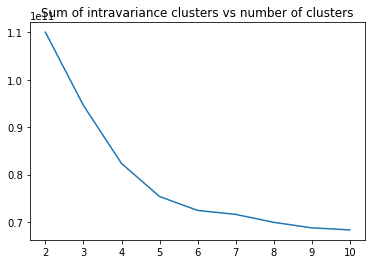

In [84]:
plt.plot(k, cost)
plt.title('Sum of intravariance clusters vs number of clusters')
plt.show()

In [85]:
# With the elbow method we chose 7 clusters as it seems to decrease almost linearly after

In [86]:
# Create the clusters column in azdias

azdias['Clusters'] = dic_kproto['akproto7'].labels_

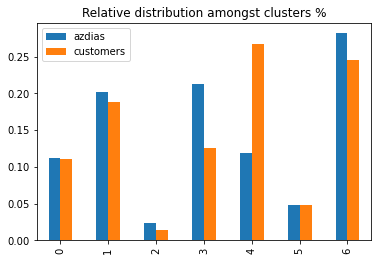

In [87]:
# Let's now apply the model to the customers, and lets vizualize the relative distribution amongst clusters for general population and customers

customers_predict = customers.drop(
    ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP', 'LNR'], axis=1)
customers['Clusters'] = dic_kproto['akproto7'].predict(
    customers_predict, categorical=cat_feat)
clusters = pd.DataFrame(data={'azdias': azdias['Clusters'].value_counts(
    normalize=True), 'customers': customers['Clusters'].value_counts(normalize=True)})
clusters.plot.bar()
plt.title('Relative distribution amongst clusters %')
plt.show()

In [88]:
# We will create a function to understand the clusters

def cluster_explain(cluster, thresh):
    """
    Input: 
    cluster, int. Corresponds to the cluster we want to understand can be between 0 and 6
    thresh, float. Corresponds to the cut-off we want to retrieve the cluster categorical features. for example,
    if 0.25 is given, only the cluster categorical features which are present in 25% or less of the population will
    be retrieved

    Output:
    a dataframe giving the cluster categorical features and their meaning and comparing with the rest of clusters
    a dataframe giving the cluster numerical features vs. distribution of the general population

    """

    # Retrieve cluster information
    clust = dic_kproto['akproto7'].cluster_centroids_[cluster]

    # Separate numerical and categorical features
    clust_num = clust[:7]
    clust_cat = clust[7:]

    # Analyze the categorical features
    azdias_freq = azdias.drop('LNR', axis=1)

    # Check what are the frequence for each categorical feature and convert to a np array
    freq = []
    for i in range(len(clust_cat)):
        freq.append(azdias_freq[azdias_freq.columns[i]].value_counts(
            normalize=True)[clust_cat[i]])
    freq = np.array(freq)

    # lets find in the categorical features the one who are less or equal to treshold.
    # We exclude the features for which value is unknown. We also exclude features for which we have no definition available.
    dic_clust_cat = {}
    for i in np.where(clust_cat != 'unknown')[0]:
        if freq[i] <= thresh:
            if azdias_freq.columns[i] in attributes['Attribute'].unique():
                dic_clust_cat[azdias_freq.columns[i]] = [clust_cat[i], freq[i]]

    # Let's analyze the content of the above dictionnary.
    for feat in dic_clust_cat.keys():
        dic_clust_cat[feat].append(
            attributes[attributes['Attribute'] == feat]['Description'].unique())
        # need to account if the value is unknown or not
        if dic_clust_cat[feat][0] == 'unknown':
            dic_clust_cat[feat].append('unknown')
        else:
            # need to take into account wether the value in the dictionnary is an int or a string
            try:
                dic_clust_cat[feat].append(attributes[(attributes['Attribute'] == feat) & (
                    attributes['Value'] == int(float(dic_clust_cat[feat][0])))]['Meaning'].values)
            except:
                dic_clust_cat[feat].append(attributes[(attributes['Attribute'] == feat) & (
                    attributes['Value'] == dic_clust_cat[feat][0])]['Meaning'].values)

    # Construct the df
    clust_cat_df = pd.DataFrame(dic_clust_cat).T
    clust_cat_df.columns = ['Value', 'Frequency', 'Description', 'Meaning']
    clust_cat_df.sort_values(by='Frequency', inplace=True)

    # Let's now look at numerical features
    clust_num_df = azdias[num_feat].describe().iloc[3:, ::]
    clust_num = pd.DataFrame(clust_num).T
    clust_num.columns = azdias[num_feat].columns
    clust_num.index = [f'cluster {cluster}']
    clust_num_df = clust_num_df.append(clust_num)

    return clust_cat_df, clust_num_df

In [89]:
# Let's look at cluster 4 which is over-represented for customers at 27% vs 12% for general population

clust_cat_df_4, clust_num_df_4 = cluster_explain(4, 0.25)

In [90]:
clust_num_df_4

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR
min,1.0,1.0,1.0,1.0,1900.0,0.0,1985.0
25%,2.0,1.0,1.0,1.0,1965.0,406.0,1992.0
50%,4.0,1.0,1.0,1.0,1968.0,549.0,1992.0
75%,9.0,1.0,2.0,1.0,1970.0,738.0,1992.0
max,595.0,23.0,45.0,6.0,2017.0,2300.0,2016.0
cluster 4,4.514265732943967,1.0042622362091616,1.1931426195269013,1.0001795620575922,1968.0357895532686,549.0129284681466,1993.072647028248


In [91]:
# On the numerical attributes nothing stands out. All features very close to the median.
# - Live mostly in 4 households building
# - One academic title holder in household
# - One adult person in household
# - One professional title holder in household
# - born in 1968 so in their 50's
# - Live in geographical area with a number of cars at the median

In [92]:
clust_cat_df_4

,Value,Frequency,Description,Meaning
LP_STATUS_FEIN,5.0,0.083585,[social status fine],[minimalistic high-income earners]
GFK_URLAUBERTYP,5.0,0.134788,[vacation habits],[Nature fans]
SEMIO_VERT,1.0,0.135137,[affinity indicating in what way the person is dreamily],[highest affinity]
FINANZTYP,4.0,0.146569,[best descirbing financial type for the person],[be prepared]
HH_EINKOMMEN_SCORE,2.0,0.158005,[estimated household net income ],[very high income]
CJT_GESAMTTYP,6.0,0.172701,[customer journey typology],[Advertising-Enthusiast with restricted Cross-Channel-Behaviour ]
SEMIO_LUST,5.0,0.190794,[affinity indicating in what way the person is sensual minded],[low affinity]
SEMIO_MAT,5.0,0.192171,[affinity indicating in what way the person is material minded],[low affinity]
SEMIO_ERL,3.0,0.202895,[affinity indicating in what way the person is eventful orientated],[high affinity]
SEMIO_DOM,6.0,0.205824,[affinity indicating in what way the person is dominant minded],[very low affinity]


In [93]:
# From the above, we can conclude that the cluster 4 which is over-represented with customers -circ. 25% of customers double of
# general population-, is representative of:
# - High income but not materialistic.
# - Nature fan
# - Dreamily person
# - Social and cultural minded

In [94]:
# Let's look at cluster 3 which is under-represented for customers at 13% vs 21% for general population

clust_cat_df_3, clust_num_df_3 = cluster_explain(3, 0.25)

In [95]:
clust_num_df_3

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,GEBURTSJAHR,KBA13_ANZAHL_PKW,MIN_GEBAEUDEJAHR
min,1.0,1.0,1.0,1.0,1900.0,0.0,1985.0
25%,2.0,1.0,1.0,1.0,1965.0,406.0,1992.0
50%,4.0,1.0,1.0,1.0,1968.0,549.0,1992.0
75%,9.0,1.0,2.0,1.0,1970.0,738.0,1992.0
max,595.0,23.0,45.0,6.0,2017.0,2300.0,2016.0
cluster 3,10.25823529101283,1.0108730648847508,1.6888667205041723,1.0002744657155374,1967.6676220184843,268.43153927762734,1992.995619104925


In [96]:
# On the numerical attributes a couple of features are quite far away from the median.
# - Live mostly in 10 households building, meaning large building. This above the 75% percentile/
# - One academic title holder in household. close to median.
# - One to two adult person in household. Tends to be more couple than cluster 4.
# - One professional title holder in household
# - born in 1968 so in their 50's
# - Live in geographical area with a small number of cars below 25% percentile.

In [97]:
clust_cat_df_3

,Value,Frequency,Description,Meaning
CAMEO_DEU_2015,8A,0.058838,[CAMEO classification 2015 - detailled classification],[Multi-culteral]
LP_LEBENSPHASE_FEIN,1.0,0.070316,[lifestage fine ],[single low-income earners of younger age]
ORTSGR_KLS9,9.0,0.103093,"[size of the community, '- classified number of inhabitants]",[> 700.000 inhabitants]
KBA13_AUTOQUOTE,1.0,0.114454,[share of cars per household within the PLZ8],[very low]
KBA13_CCM_2500,1.0,0.114977,[share of cars with 2000ccm to 2499ccm within the PLZ8],[very low]
KBA13_KW_121,1.0,0.118608,[share of cars with an engine power more than 120 KW - PLZ8],[very low]
INNENSTADT,2.0,0.122358,[distance to the city centre],[distance to the city centre 3 km]
KBA13_BJ_2009,1.0,0.134545,[share of cars built in 2009 within the PLZ8],[very low]
KBA13_CCM_2501,1.0,0.136663,[share of cars with more than 2500ccm within the PLZ8],[very low]
CAMEO_DEUG_2015,8.0,0.15085,[CAMEO classification 2015 - Uppergroup],[working class]


In [98]:
# From the above, we can conclude that the cluster 3 which is under-represented with customers -circ. 13% of customers
# vs 21% general population-, is representative of:
# - Low income earner without vacation habit
# - Working class
# - Live in area with low number of cars, especially for more expensive ones
# - Live in area with high share of multifamily buildings, high density of population and large size community.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### a. First catboost implementation

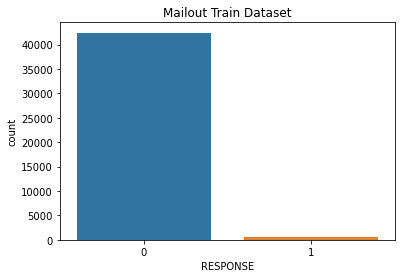

In [99]:
# The mailout train dataset is very imbalanced

sns.countplot(data=mailout_train, x='RESPONSE')
plt.title('Mailout Train Dataset')
plt.show()

In [100]:
# The metric which we will use to select the best model will be the AUC

In [101]:
# Given the number of categorical features we will use the catboost algorithm, which does not require preprocessing for
# categorical variables.

In [102]:
# We launch a first catboost modelization with default parameters at the exception of:
# - logging_level='Silent': we don't want the output of the by default 1000 iterations
# - early_stopping_round=200 : if there is no improvement of the AUC on the validation set after 200 iterations, there is no
# further iterations. This prevents overfitting and also reduce computation time.
# - eval_metric='AUC': this enables to select the best model for the AUC on the validation set

In [103]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier

In [104]:
X = mailout_train.drop(['RESPONSE', 'LNR'], axis=1)
y = mailout_train['RESPONSE']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

num_feat_loc = []
for col in X.select_dtypes(float).columns:
    num_feat_loc.append(X.columns.get_loc(col))

cat_feat_loc = []
for col in X.select_dtypes('object').columns:
    cat_feat_loc.append(X.columns.get_loc(col))

# Inpute missing numerical values for X_train with the median
imputer_num = SimpleImputer(strategy='median')
X_train_num = X_train.iloc[::, num_feat_loc]
X_train_num = imputer_num.fit_transform(X_train_num)
X_test_num = X_test.iloc[::, num_feat_loc]

# Just use transform on the test set to avoid data leakage
X_test_num = imputer_num.transform(X_test_num)

X_train.iloc[::, num_feat_loc] = X_train_num
X_test.iloc[::, num_feat_loc] = X_test_num

# Use catboost
cat_base = CatBoostClassifier(eval_metric='AUC', task_type='GPU',
                              cat_features=cat_feat_loc, early_stopping_rounds=200)
cat_base.fit(X_train, y_train, eval_set=(X_test, y_test),
             use_best_model=True,logging_level='Silent')

C:\Users\mrnpe\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [105]:
cat_base.best_score_

{'learn': {'Logloss': 0.056081770790358795, 'AUC': 0.8474918603897095},
 'validation': {'Logloss': 0.061146856010136745, 'AUC': 0.7783129811286926}}

In [106]:
# The AUC on validation set is 0.778 using catboost default parameters. The AUC on the learning set is 0.85
# It is an indication of overfitting.

In [107]:
# Let's see on the mailout_test on Kaggle platform
test = mailout_test.drop('LNR', axis=1)

In [108]:
# Input missing data on test set

test_num_feat_loc = []
for col in X.select_dtypes(float).columns:
    test_num_feat_loc.append(X.columns.get_loc(col))

In [109]:
# Input missing numerical values using the inputter fit on the train set
test_num = imputer_num.transform(test.iloc[::, test_num_feat_loc])

In [110]:
test.iloc[::, test_num_feat_loc] = test_num

In [111]:
cat_base_pred = cat_base.predict_proba(test)

In [112]:
cat_base_pred = pd.DataFrame(
    {'LNR': mailout_test['LNR'], 'RESPONSE': cat_base_pred[:, 1]})

In [113]:
cat_base_pred.to_csv('cat_base_pred.csv', index=False)

In [114]:
# Kaggle score is 0.79226

In [115]:
# Let's analyze the important features

from sklearn.metrics import roc_auc_score

The below code runs features permutation analysis and save the results as a csv file.
It takes quite some time to run on my computer
The code is therefore marked as a comment to enable to run the whole notebook, without excessive time.

In [116]:
# # Compute the base AUC
# base_AUC = roc_auc_score(y_test, cat_base.predict_proba(X_test)[:, 1])


# imp = {}

# # We select each feature on the test set
# for feat in X_test.columns:
#     mean = []
#     # For each feature we shuffle 5 times randomly the values. And we compute the average AUC obtained accross the 5 permutations
#     for i in range(5):
#         imp_test = X_test.copy()
#         imp_test.reset_index(drop=True, inplace=True)
#         imp_test.loc[:, feat] = imp_test[feat].sample(
#             frac=1).reset_index(drop=True)
#         mean.append(roc_auc_score(y_test, cat_base.predict_proba(imp_test)[:, 1]))

#     # The feature importance is defined as the base AUC minus the average AUC after having shuffled 5 times the feature.
#     # If the feature is important then, the random permutations should make the new AUC drop
#     imp[feat] = base_AUC-np.array(mean).mean()

# importance = pd.Series(imp)
# importance.sort_values(ascending=False, inplace=True)

# importance.to_csv('Feature_imp_baseline.csv')

In [117]:
importance = pd.read_csv('Feature_imp_baseline.csv')

In [118]:
importance[importance['0']>0]

,Unnamed: 0,0
0,D19_SOZIALES,0.242544
1,EINGEFUEGT_AM,0.041555
2,ANZ_STATISTISCHE_HAUSHALTE,0.031231
3,EXTSEL992,0.001917
4,CAMEO_DEU_2015,0.000857


In [119]:
X['D19_SOZIALES'].unique()

array(['1.0', '5.0', '2.0', '3.0', '4.0', 'unknown', '0.0'], dtype=object)

In [120]:
customers[customers['Clusters'] == 4]['D19_SOZIALES'].value_counts()

unknown    46660
1.0         2892
0.0          996
5.0          234
2.0          195
4.0          159
3.0          145
Name: D19_SOZIALES, dtype: int64

In [121]:
# No information on the meaning of D19_SOZIALES but looking at range of values and the definition of other 'D19' features
# It is a categorical variable
# It is likely related to transactional activity in the SOZIALES product group
# It is mostly an unknown information for cluster 4 which was the one with an over-representation of customers

In [122]:
X['EINGEFUEGT_AM'].nunique()

1600

In [123]:
# No information on the meaning. It looks like a time stamp as there are 1600 different values.
# It might be worth to try to engineer this feature by extracting the year, month, day

In [124]:
X['EINGEFUEGT_AM'].apply(lambda x: x[-8:]).value_counts()

00:00:00    35185
unknown      7777
Name: EINGEFUEGT_AM, dtype: int64

In [125]:
# So we never have the information on the hour, let's retrieve the year and the month

In [126]:
X['EINGEFUEGT_AM_year'] = X['EINGEFUEGT_AM'].apply(
    lambda x: x[:4] if x != 'unknown' else x)
X['EINGEFUEGT_AM_month'] = X['EINGEFUEGT_AM'].apply(
    lambda x: x[5:7] if x != 'unknown' else x)

In [127]:
X['ANZ_STATISTISCHE_HAUSHALTE'].unique()

array(['13.0', '1.0', '4.0', '44.0', '11.0', 'unknown', '2.0', '8.0',
       '7.0', '3.0', '5.0', '10.0', '6.0', '101.0', '74.0', '20.0',
       '19.0', '47.0', '15.0', '14.0', '9.0', '30.0', '16.0', '109.0',
       '18.0', '40.0', '17.0', '33.0', '32.0', '23.0', '12.0', '25.0',
       '0.0', '28.0', '29.0', '22.0', '24.0', '53.0', '57.0', '36.0',
       '174.0', '38.0', '152.0', '136.0', '72.0', '86.0', '51.0', '55.0',
       '27.0', '21.0', '65.0', '31.0', '49.0', '39.0', '48.0', '34.0',
       '46.0', '41.0', '64.0', '68.0', '78.0', '26.0', '62.0', '144.0',
       '112.0', '45.0', '37.0', '52.0', '66.0', '233.0', '88.0', '35.0',
       '60.0', '342.0', '214.0', '81.0', '61.0', '77.0', '75.0', '84.0',
       '138.0', '54.0', '140.0', '95.0', '42.0', '83.0', '67.0', '56.0',
       '91.0', '115.0', '89.0', '113.0', '117.0', '43.0', '59.0', '85.0',
       '87.0', '125.0', '123.0', '127.0', '122.0', '121.0', '131.0',
       '161.0', '98.0', '130.0', '274.0', '58.0', '322.0', '69.0', '63.

In [128]:
X['ANZ_STATISTISCHE_HAUSHALTE'].nunique()

174

In [129]:
# No information on the meaning. It actually rather look like a numerical variable with integers rather than a categorical
# variable. We will relaunch the model treating it as numerical.

In [130]:
# Let's rerun previous model but this time we will replace EINGEFUEGT_AM by year and month

In [131]:
X = mailout_train.drop(['RESPONSE', 'LNR'], axis=1)
y = mailout_train['RESPONSE']

X['EINGEFUEGT_AM_year'] = X['EINGEFUEGT_AM'].apply(
    lambda x: x[:4] if x != 'unknown' else x)
X['EINGEFUEGT_AM_month'] = X['EINGEFUEGT_AM'].apply(
    lambda x: x[5:7] if x != 'unknown' else x)
X.drop('EINGEFUEGT_AM', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

num_feat_loc = []
for col in X.select_dtypes(float).columns:
    num_feat_loc.append(X.columns.get_loc(col))

cat_feat_loc = []
for col in X.select_dtypes('object').columns:
    cat_feat_loc.append(X.columns.get_loc(col))

# Inpute missing numerical values for X_train with the median
imputer_num = SimpleImputer(strategy='median')
X_train_num = X_train.iloc[::, num_feat_loc]
X_train_num = imputer_num.fit_transform(X_train_num)
X_test_num = X_test.iloc[::, num_feat_loc]

# Just use transform on the test set to avoid data leakage
X_test_num = imputer_num.transform(X_test_num)

X_train.iloc[::, num_feat_loc] = X_train_num
X_test.iloc[::, num_feat_loc] = X_test_num

# Use catboost
cat_2 = CatBoostClassifier(eval_metric='AUC', task_type='GPU',
                           cat_features=cat_feat_loc, early_stopping_rounds=200)
cat_2.fit(X_train, y_train, eval_set=(X_test, y_test),
          use_best_model=True, logging_level='Silent')

C:\Users\mrnpe\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [132]:
cat_2.best_score_

{'learn': {'Logloss': 0.05003017236816678, 'AUC': 0.8838298916816711},
 'validation': {'Logloss': 0.06132105459933524, 'AUC': 0.7764750719070435}}

In [133]:
# It slightly deteriorated the performance from 0.778 to 0.776
# Let's now try the baseline but we declare ANZ_STATISTISCHE_HAUSHALTE as numerical

In [134]:
X = mailout_train.drop(['RESPONSE', 'LNR'], axis=1)
y = mailout_train['RESPONSE']

# First replace unknown by nan
X['ANZ_STATISTISCHE_HAUSHALTE'].replace(
    to_replace='unknown', value=np.nan, inplace=True)
X['ANZ_STATISTISCHE_HAUSHALTE'] = X['ANZ_STATISTISCHE_HAUSHALTE'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

num_feat_loc = []
for col in X.select_dtypes(float).columns:
    num_feat_loc.append(X.columns.get_loc(col))

cat_feat_loc = []
for col in X.select_dtypes('object').columns:
    cat_feat_loc.append(X.columns.get_loc(col))

# Inpute missing numerical values for X_train with the median
imputer_num = SimpleImputer(strategy='median')
X_train_num = X_train.iloc[::, num_feat_loc]
X_train_num = imputer_num.fit_transform(X_train_num)
X_test_num = X_test.iloc[::, num_feat_loc]

# Just use transform on the test set to avoid data leakage
X_test_num = imputer_num.transform(X_test_num)

X_train.iloc[::, num_feat_loc] = X_train_num
X_test.iloc[::, num_feat_loc] = X_test_num

# Use catboost
cat_3 = CatBoostClassifier(eval_metric='AUC', task_type='GPU',
                           cat_features=cat_feat_loc, early_stopping_rounds=200)
cat_3.fit(X_train, y_train, eval_set=(X_test, y_test),
          use_best_model=True, logging_level='Silent')

C:\Users\mrnpe\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [135]:
cat_3.best_score_

{'learn': {'Logloss': 0.055109411030759274, 'AUC': 0.8592174649238586},
 'validation': {'Logloss': 0.06082880421306337, 'AUC': 0.7891595363616943}}

In [136]:
# It improved the performance from 0.778 to 0.789. Let's now look at feature importance on this new model

The below code runs features permutation analysis and save the results as a csv file.
It takes quite some time to run on my computer
The code is therefore marked as a comment to enable to run the whole notebook, without excessive time.

In [137]:
# base_AUC = roc_auc_score(y_test, cat_3.predict_proba(X_test)[:, 1])

# imp = {}
# for feat in X_test.columns:
#     mean = []
#     for i in range(5):
#         imp_test = X_test.copy()
#         imp_test.reset_index(drop=True, inplace=True)
#         imp_test.loc[:, feat] = imp_test[feat].sample(
#             frac=1).reset_index(drop=True)
#         mean.append(roc_auc_score(y_test, cat_3.predict_proba(imp_test)[:, 1]))
#     imp[feat] = base_AUC-np.array(mean).mean()
    
# importance_cat_3 = pd.Series(imp)
# importance_cat_3.sort_values(ascending=False, inplace=True)

# # We save the file as it took a long time to compute
# importance_cat_3.to_csv('Feature_imp_cat_3.csv')

In [138]:
importance_cat_3=pd.read_csv('Feature_imp_cat_3.csv')

In [139]:
importance_cat_3[importance_cat_3['0']>0]

,Unnamed: 0,0
0,D19_SOZIALES,0.269052
1,EINGEFUEGT_AM,0.054603
2,EXTSEL992,0.012945
3,VERDICHTUNGSRAUM,0.004648
4,CAMEO_INTL_2015,0.001438
5,CAMEO_DEU_2015,0.000387


In [140]:
# Let's see if we achieve a performance close to cat_3 at 0.7891 if we reduce the features to the above

In [141]:
X = mailout_train.drop(['RESPONSE', 'LNR'], axis=1)[['D19_SOZIALES', 'EINGEFUEGT_AM',
                                                     'EXTSEL992', 'VERDICHTUNGSRAUM', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']]
y = mailout_train['RESPONSE']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

cat_feat_loc = []
for col in X.select_dtypes('object').columns:
    cat_feat_loc.append(X.columns.get_loc(col))

# Use catboost
cat_4 = CatBoostClassifier(eval_metric='AUC', task_type='GPU',
                           cat_features=cat_feat_loc, early_stopping_rounds=200)
cat_4.fit(X_train, y_train, eval_set=(X_test, y_test),
          use_best_model=True, logging_level='Silent')

In [142]:
cat_4.best_score_

{'learn': {'Logloss': 0.057302647792610475, 'AUC': 0.8320354223251343},
 'validation': {'Logloss': 0.06063575868395357, 'AUC': 0.792511522769928}}

In [143]:
# The performance is slightly improved from 0.7891 to 0.7925

In [144]:
cat4_pred = cat_4.predict_proba(
    test[['D19_SOZIALES', 'EINGEFUEGT_AM', 'EXTSEL992', 'VERDICHTUNGSRAUM', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']])

In [145]:
df_cat4 = pd.DataFrame(
    {'LNR': mailout_test['LNR'], 'RESPONSE': cat4_pred[:, 1]})

In [146]:
df_cat4.to_csv('redfeat.csv', index=False)

In [147]:
# Score of 0.79223 on Kaggle. It is a very small decrease compared to the baseline predicitions which scored 0.79226 on Kaggle.

In [148]:
# Let's now perform tuning with Hyperopt library

from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, hp

In [149]:
trials = Trials()

In [150]:
# We need to define the parameters search space

parameter_space = {'iterations': hp.choice('iterations', [500, 1000, 1500, 2000]), 'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.07)),
                   'depth': hp.quniform('depth', 6, 10, 1), 'l2_leaf_reg': hp.quniform('l2_leaf_reg', 3, 10, 1), 'eval_metric': 'AUC', 'task_type': 'GPU', 'early_stopping_rounds': 300, 'class_weights': hp.choice('class_weights', [None, [1, 50], [1, 100], [1, 150], [1, 200], [1, 300]])}

In [151]:
# We then define an objective function to minimize

def objective(par):
    # We will use a 3 fold stratified split
    skf = StratifiedKFold(n_splits=3)
    auc_opt = []
    auc_std = []
    y = mailout_train['RESPONSE']
    X = mailout_train.drop(['RESPONSE', 'LNR'], axis=1)[
        ['D19_SOZIALES', 'EINGEFUEGT_AM', 'EXTSEL992', 'VERDICHTUNGSRAUM', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']]
    cat_opt = CatBoostClassifier(**par)

    cat_feat_loc = []
    for col in X.select_dtypes('object').columns:
        cat_feat_loc.append(X.columns.get_loc(col))

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        # Use catboost
        cat_opt.fit(X_train, y_train, eval_set=(X_test, y_test),
                    use_best_model=True, cat_features=cat_feat_loc, logging_level='Silent')

        auc_opt.append(cat_opt.best_score_['validation']['AUC'])
        auc_std.append(cat_opt.best_score_['validation']['AUC'])
    
    # Hyperopt need a function to minimize. We simply multiply by -1 the average AUC obtained accross the 3 folds.
    
    return {'loss': -1*np.array(auc_opt).mean(), 'status': STATUS_OK, 'parameters': par, 'std': np.array(auc_std).std(), 'fitted_model': cat_opt}

The below takes a long time to run.
The results of the optimization are saved as a pickle file.
The code is therefore marked as a comment to enable to run the whole notebook, without excessive time.

In [152]:
# opt = fmin(objective, space=parameter_space,
#            algo=tpe.suggest, trials=trials, max_evals=100)
# pickle.dump(trials, open("cat_4_tpe_100.p", "wb"))

In [153]:
# Kaggle score for cat_4_tpe_100

trials = pickle.load(open("cat_4_tpe_100.p", "rb"))

In [154]:
trials.best_trial

{'state': 2,
 'tid': 28,
 'spec': None,
 'result': {'loss': -0.7766920228799185,
  'status': 'ok',
  'parameters': {'class_weights': None,
   'depth': 8.0,
   'early_stopping_rounds': 300,
   'eval_metric': 'AUC',
   'iterations': 500,
   'l2_leaf_reg': 7.0,
   'learning_rate': 0.05878812536974758,
   'task_type': 'GPU'},
  'std': 0.013470546010193062,
  'fitted_model': <catboost.core.CatBoostClassifier at 0x2bf595b46a0>},
 'misc': {'tid': 28,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'class_weights': [28],
   'depth': [28],
   'iterations': [28],
   'l2_leaf_reg': [28],
   'learning_rate': [28]},
  'vals': {'class_weights': [0],
   'depth': [8.0],
   'iterations': [0],
   'l2_leaf_reg': [7.0],
   'learning_rate': [0.05878812536974758]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 4, 20, 21, 44, 50, 838000),
 'refresh_time': datetime.datetime(2021, 4, 20, 21, 46, 36, 816000)}

In [155]:
# retrieve the best fitted model
cat_4_tpe_100 = trials.best_trial['result']['fitted_model']

In [156]:
test = mailout_test[['D19_SOZIALES', 'EINGEFUEGT_AM', 'EXTSEL992',
                     'VERDICHTUNGSRAUM', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']]

In [157]:
pred_cat_4_tpe_100 = cat_4_tpe_100.predict_proba(test)

In [158]:
df_cat4_tpe_100 = pd.DataFrame(
    {'LNR': mailout_test['LNR'], 'RESPONSE': pred_cat_4_tpe_100[:, 1]})

In [159]:
df_cat4_tpe_100.to_csv('redfeat_tpe_100.csv', index=False)

In [160]:
# Kaggle score of 0.7843

The below takes a long time to run.
The results of the optimization are saved as a pickle file.
The code is therefore marked as a comment to enable to run the whole notebook, without excessive time.

In [161]:
# trials=Trials()
# opt = fmin(objective, space=parameter_space,
#            algo=tpe.rand.suggest, trials=trials, max_evals=100)
# pickle.dump(trials, open("cat_4_rnd_100.p", "wb"))

In [162]:
# Kaggle score for cat_4_rnd_100

trials = pickle.load(open("cat_4_rnd_100.p", "rb"))

In [163]:
trials.best_trial

{'state': 2,
 'tid': 35,
 'spec': None,
 'result': {'loss': -0.7755987644195557,
  'status': 'ok',
  'parameters': {'class_weights': None,
   'depth': 9.0,
   'early_stopping_rounds': 300,
   'eval_metric': 'AUC',
   'iterations': 500,
   'l2_leaf_reg': 5.0,
   'learning_rate': 0.03677614050093655,
   'task_type': 'GPU'},
  'std': 0.01655049823619449,
  'fitted_model': <catboost.core.CatBoostClassifier at 0x2c04842a4f0>},
 'misc': {'tid': 35,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'class_weights': [35],
   'depth': [35],
   'iterations': [35],
   'l2_leaf_reg': [35],
   'learning_rate': [35]},
  'vals': {'class_weights': [0],
   'depth': [9.0],
   'iterations': [0],
   'l2_leaf_reg': [5.0],
   'learning_rate': [0.03677614050093655]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 4, 20, 18, 23, 19, 887000),
 'refresh_time': datetime.datetime(2021, 4, 20, 18, 25, 18, 492000)}

In [164]:
cat_4_rnd_100 = trials.best_trial['result']['fitted_model']

In [165]:
pred_cat_4_rnd_100 = cat_4_rnd_100.predict_proba(test)

In [166]:
df_cat4_rnd_100 = pd.DataFrame(
    {'LNR': mailout_test['LNR'], 'RESPONSE': pred_cat_4_rnd_100[:, 1]})

In [167]:
df_cat4_tpe_100.to_csv('redfeat_rnd_100.csv', index=False)

In [168]:
# Kaggle score of 0.78435

In [169]:
# let's try to tune our base model with weight

parameter_space = {'iterations': hp.choice('iterations', [500, 1000, 1500, 2000]), 'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.07)),
                   'depth': hp.quniform('depth', 6, 10, 1), 'l2_leaf_reg': hp.quniform('l2_leaf_reg', 3, 10, 1), 'eval_metric': 'AUC', 'task_type': 'CPU', 'early_stopping_rounds': 100, 'class_weights': hp.choice('class_weights', [None, [1, 50], [1, 100], [1, 150], [1, 200], [1, 300]])}

In [170]:
trials = Trials()

In [171]:
def objective_base(par):
    skf = StratifiedKFold(n_splits=3)
    auc_opt = []
    auc_std = []
    y = mailout_train['RESPONSE']
    X = mailout_train.drop(['RESPONSE', 'LNR'], axis=1)
    X['ANZ_STATISTISCHE_HAUSHALTE'].replace(
        to_replace='unknown', value=np.nan, inplace=True)
    X['ANZ_STATISTISCHE_HAUSHALTE'] = X['ANZ_STATISTISCHE_HAUSHALTE'].astype(
        float)
    cat_opt = CatBoostClassifier(**par)

    cat_feat_loc = []
    for col in X.select_dtypes('object').columns:
        cat_feat_loc.append(X.columns.get_loc(col))

    num_feat_loc = []
    for col in X.select_dtypes(float).columns:
        num_feat_loc.append(X.columns.get_loc(col))

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        # Inpute missing numerical values for X_train with the median
        imputer_num = SimpleImputer(strategy='median')
        X_train_num = X_train.iloc[::, num_feat_loc]
        X_train_num = imputer_num.fit_transform(X_train_num)
        X_test_num = X_test.iloc[::, num_feat_loc]

        # Just use transform on the test set to avoid data leakage
        X_test_num = imputer_num.transform(X_test_num)

        X_train.iloc[::, num_feat_loc] = X_train_num
        X_test.iloc[::, num_feat_loc] = X_test_num

        # Use catboost
        cat_opt.fit(X_train, y_train, eval_set=(X_test, y_test),
                    use_best_model=True, cat_features=cat_feat_loc, logging_level='Silent')

        auc_opt.append(cat_opt.best_score_['validation']['AUC'])
        auc_std.append(cat_opt.best_score_['validation']['AUC'])

    return {'loss': -1*np.array(auc_opt).mean(), 'status': STATUS_OK, 'parameters': par, 'std': np.array(auc_std).std(), 'fitted_model': cat_opt}

In [172]:
# opt = fmin(objective_base, space=parameter_space,
#            algo=tpe.rand.suggest, trials=trials, max_evals=50)
# pickle.dump(trials, open("cat_base_rnd50.p", "wb"))

In [173]:
trials = pickle.load(open("cat_base_rnd50.p", "rb"))

In [174]:
trials.best_trial

{'state': 2,
 'tid': 37,
 'spec': None,
 'result': {'loss': -0.7813838070685565,
  'status': 'ok',
  'parameters': {'class_weights': (1, 100),
   'depth': 7.0,
   'early_stopping_rounds': 100,
   'eval_metric': 'AUC',
   'iterations': 500,
   'l2_leaf_reg': 5.0,
   'learning_rate': 0.01291491309200495,
   'task_type': 'CPU'},
  'std': 0.019734415203351965,
  'fitted_model': <catboost.core.CatBoostClassifier at 0x2bec3c7a220>},
 'misc': {'tid': 37,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'class_weights': [37],
   'depth': [37],
   'iterations': [37],
   'l2_leaf_reg': [37],
   'learning_rate': [37]},
  'vals': {'class_weights': [2],
   'depth': [7.0],
   'iterations': [0],
   'l2_leaf_reg': [5.0],
   'learning_rate': [0.01291491309200495]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 4, 22, 18, 26, 43, 346000),
 'refresh_time': datetime.datetime(2021, 4, 22, 18, 34, 48, 663000)}

In [175]:
cat_base_rnd50=trials.best_trial['result']['fitted_model']

In [176]:
test = mailout_test.drop('LNR', axis=1)
test['ANZ_STATISTISCHE_HAUSHALTE'].replace(
    to_replace='unknown', value=np.nan, inplace=True)
test['ANZ_STATISTISCHE_HAUSHALTE'] = test['ANZ_STATISTISCHE_HAUSHALTE'].astype(
    float)

pred_cat_base_rnd50 = cat_base_rnd50.predict_proba(test)

df_cat_base_rnd50 = pd.DataFrame(
    {'LNR': mailout_test['LNR'], 'RESPONSE': pred_cat_base_rnd50[:, 1]})
df_cat_base_rnd50.to_csv('cat_base_rnd50.csv', index=False)

In [177]:
# Kaggle score 0.80612. This is the best submission and ranks 30 out of 361.

The below code runs features permutation analysis and save the results as a csv file.
It takes quite some time to run on my computer
The code is therefore marked as a comment to enable to run the whole notebook, without excessive time.

In [178]:
# base_AUC = roc_auc_score(y_test, cat_base_rnd50.predict_proba(X_test)[:, 1])

# imp = {}

# for feat in X_test.columns:
#     mean = []
#     for i in range(5):
#         imp_test = X_test.copy()
#         imp_test.reset_index(drop=True, inplace=True)
#         imp_test.loc[:, feat] = imp_test[feat].sample(
#             frac=1).reset_index(drop=True)
#         mean.append(roc_auc_score(y_test, cat_base_rnd50.predict_proba(imp_test)[:, 1]))
#     imp[feat] = base_AUC-np.array(mean).mean()
   
    
# importance_cat_base_rnd50 = pd.Series(imp)
# importance_cat_base_rnd50.sort_values(ascending=False, inplace=True)

# # We save the file as it took a long time to compute
# importance_cat_base_rnd50.to_csv('Feature_imp_cat_base_rnd50.csv')

In [179]:
importance_cat_base_rnd50=pd.read_csv('Feature_imp_cat_base_rnd50.csv',header=0,names=['Feature','Importance'])

In [180]:
importance_cat_base_rnd50[importance_cat_base_rnd50['Importance']>0].iloc[:11]

,Feature,Importance
0,D19_SOZIALES,0.198505
1,D19_KONSUMTYP_MAX,0.006600
2,KBA05_KRSHERST3,0.006152
3,KBA13_HERST_EUROPA,0.004832
4,RT_SCHNAEPPCHEN,0.004449
5,VHN,0.004215
6,WOHNLAGE,0.004198
7,SEMIO_RAT,0.003953
8,KBA13_KW_60,0.003922
9,KBA13_OPEL,0.003739


##### Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.